In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from scipy.stats import skew

%matplotlib inline

/home/dheeraj/repos/learn-ML/env/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/dheeraj/repos/learn-ML/env/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load training dataset
train_df = pd.read_csv('dataset/kaggle-house-price/train.csv')
rows_train = train_df.shape[0]
test_df = pd.read_csv('dataset/kaggle-house-price/test.csv')
all_data = pd.concat([train_df, test_df])

# null values
def null_values_per_col(df):
    """
    Returns a Pandas Series containing the number of null values for each
    column which has atleast 1 null value.
    """
    null_cols_all = df.apply(lambda x: x.size - x.count())
    null_cols = pd.Series()

    for col, val in null_cols_all.iteritems():
        if val > 0:
            null_cols[col] = val

    return null_cols

print "null values:"
null_values_per_col(all_data)

null values:


Alley           2721
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2348
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2814
PoolQC          2909
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

**Fill null values 'NA' wherever possible.**

In [3]:
def fill_cols_with_val(df, cols, val):
    """
    Fill the columns specified in the DataFrame df with val
    """
    for col in cols:
        df[col].fillna(val, inplace=True)

NA_cols = ['Alley', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
           'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'BsmtFinType2',
           'BsmtFinType1', 'BsmtExposure', 'BsmtCond', 'BsmtQual']

# fill with 'NA'
fill_cols_with_val(all_data, NA_cols, 'NA')

# remaining columns with null values
null_values_per_col(all_data)

BsmtFinSF1         1
BsmtFinSF2         1
BsmtFullBath       2
BsmtHalfBath       2
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Functional         2
GarageArea         1
GarageCars         1
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

**Fill rest of the null values with appropriate values.**

In [4]:
zero_cols = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath',
             'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'TotalBsmtSF']

# fill with zero
fill_cols_with_val(all_data, zero_cols, 0)

mode_cols = ['Exterior1st', 'Exterior2nd', 'Electrical', 'Functional', 'KitchenQual',
             'MSZoning', 'SaleType', 'Utilities']

# fill with mode
for col in mode_cols:
    all_data[col].fillna(all_data[col].mode()[0], inplace=True)

all_data['MasVnrType'].fillna('None', inplace=True)
all_data['LotFrontage'].fillna(all_data['LotFrontage'].mean(), inplace=True)

# remaining columns with null values
null_values_per_col(all_data)

GarageYrBlt     159
SalePrice      1459
dtype: int64

**Find skewed features and log transform them**

In [5]:
numeric_cols = all_data.dtypes[all_data.dtypes != 'object'].index
date_price_cols = ['GarageYrBlt', 'MoSold', 'YearBuilt',
                   'YearRemodAdd', 'YrSold', 'SalePrice']

# remove date and price fields from numeric cols
for col in date_price_cols:
    numeric_cols = numeric_cols.delete(np.argwhere(numeric_cols == col))

skewed_features = all_data[numeric_cols].apply(lambda x: skew(x))
skewed_features = skewed_features[skewed_features > 0.7]
skewed_features = skewed_features.index

# log transform skewed features
all_data[skewed_features] = all_data[skewed_features].apply(lambda x: np.log1p(x))

**Encode categories using LabelEncoder**

In [6]:
# Encode categories
only_strings = all_data.select_dtypes(include=['object'])
only_strings = only_strings.apply(LabelEncoder().fit_transform)
all_data[only_strings.columns.values] = only_strings
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,6.753438,6.751101,0.0,1,3,0,4,4,6.561031,0.0,...,8,0.0,1,2.197225,6.753438,0,0.000000,2003,2003,2008
1,7.141245,0.000000,0.0,1,3,0,4,1,6.886532,0.0,...,8,0.0,1,1.945910,7.141245,0,5.700444,1976,1976,2007
2,6.825460,6.765039,0.0,1,3,0,4,2,6.188264,0.0,...,8,0.0,1,1.945910,6.825460,0,0.000000,2001,2002,2008
3,6.869014,6.629363,0.0,1,3,0,1,4,5.379897,0.0,...,8,0.0,1,2.079442,6.629363,0,0.000000,1915,1970,2006
4,7.044033,6.960348,0.0,1,4,0,4,0,6.486161,0.0,...,8,0.0,1,2.302585,7.044033,0,5.262690,2000,2000,2008


**Find important features**

In [7]:
train_data = all_data[0:rows_train]
# log transform sale price since its skewed
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])
test_data = all_data[rows_train:]
test_data.drop('SalePrice', axis=1, inplace=True)

x_features = train_data.columns.values.tolist()
x_features.remove('SalePrice')
# remove 'GarageYrBlt' since its unimportant and no default can be applied.
x_features.remove('GarageYrBlt')

X = train_data[x_features]
y = train_data['SalePrice']

rfr = RandomForestRegressor()
rfr.fit(X, y)
feature_importance = rfr.feature_importances_

/home/dheeraj/repos/learn-ML/env/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/dheeraj/repos/learn-ML/env/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


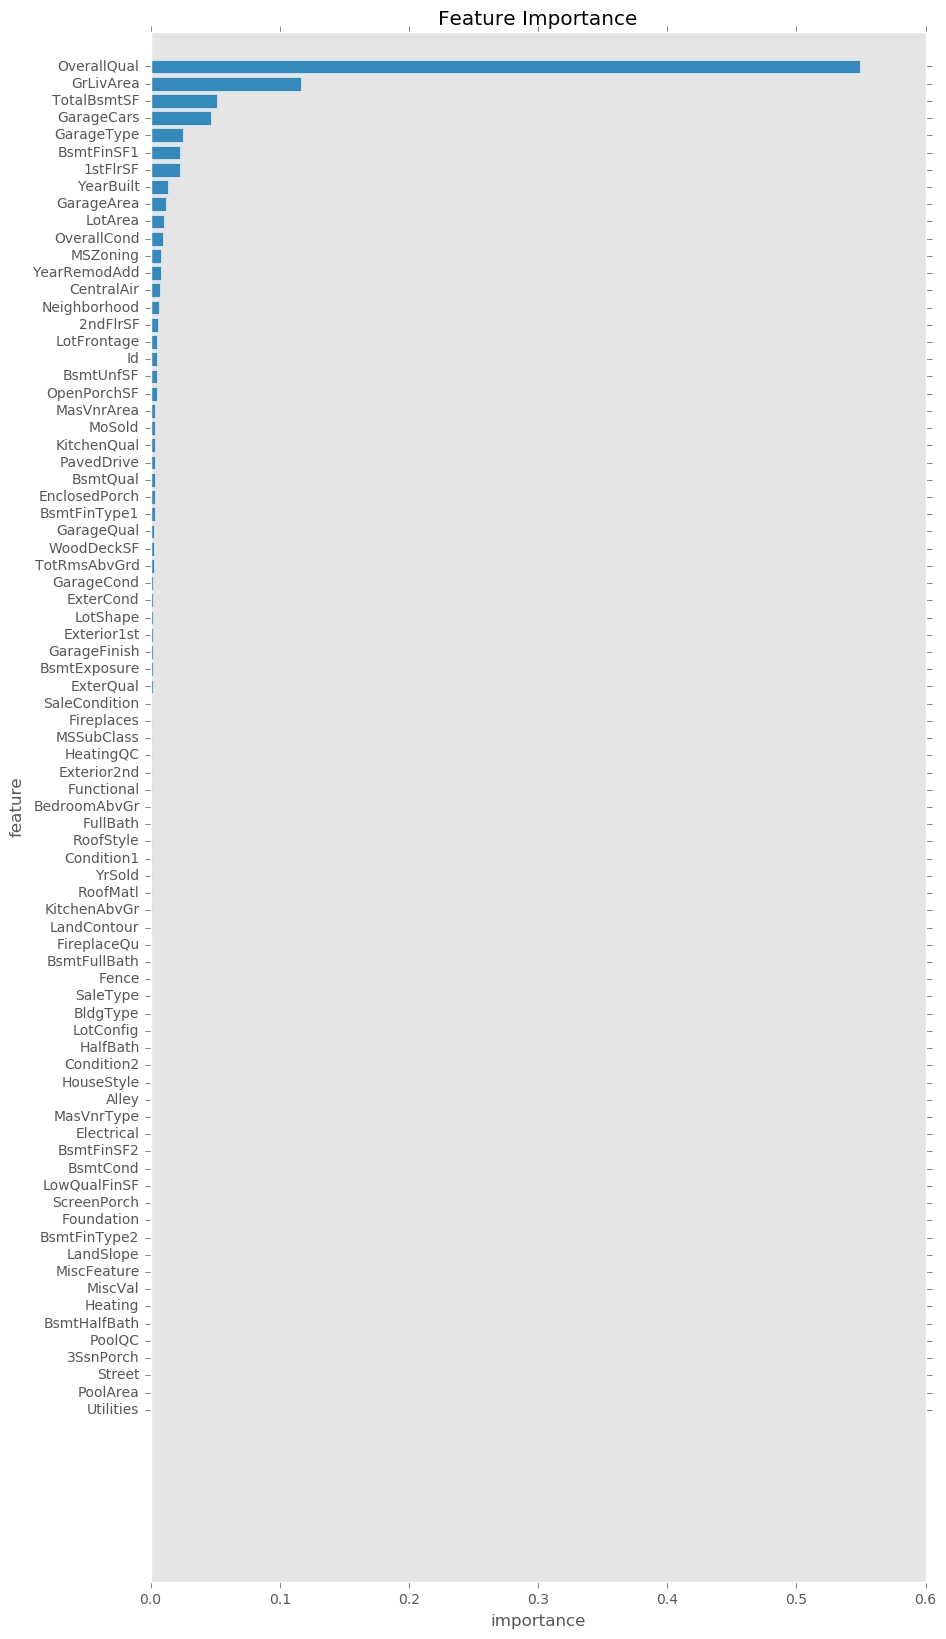

array(['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars',
       'GarageType', 'BsmtFinSF1', '1stFlrSF', 'YearBuilt', 'GarageArea',
       'LotArea'], 
      dtype='|S13')

In [8]:
def plot_feature_importance(importances, features):
    """
    Plot the feature importances as a horizontal bar chart (in ascending order)
    x-axis = value of feature importance passed as the var 'importances'
    y-axis = feature name as labels passed as the var 'features'
    """
    sorted_idx = np.argsort(importances)
    sorted_importance = importances[sorted_idx]
    sorted_features = np.array(features)[sorted_idx]
    plt.barh(np.arange(len(sorted_importance)), sorted_importance,
         align='center')
    plt.yticks(range(len(sorted_features)), sorted_features)
    plt.xlabel("importance")
    plt.ylabel("feature")
    plt.title("Feature Importance")
    plt.grid()
    plt.show()

plt.style.use('ggplot')
plt.figure(figsize=[10, 20])
plot_feature_importance(feature_importance, x_features)

def top_n_features(importances, features, n=None):
    """
    Return the top n features
    """
    if not n:
        n = len(features)
    sorted_idx = np.argsort(importances)
    sorted_features = np.array(features)[sorted_idx][::-1]
    return sorted_features[: n]

top_10_features = top_n_features(feature_importance, x_features, 10)
top_10_features

In [9]:
X = X[top_10_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [10]:
y_true = y_test
r2_score(y_true, y_pred)

0.79305038623099344

In [11]:
test_X = test_data[top_10_features]
y_pred = lr.predict(test_X)
test_data['SalePrice'] = y_pred

id_price = test_data[['Id', 'SalePrice']]
id_price.to_csv('outputs/house_price_lin_reg1.csv', index=False)

/home/dheeraj/repos/learn-ML/env/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
